In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sb
sb.set()
import scipy.optimize as optimization
import datetime as dt
from datetime import timedelta
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,6
import math
import scipy.stats
import matplotlib.pyplot as plt
import time
from ipywidgets import Checkbox
import pandas_datareader as pdr
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.append('../../ModernPortfolio_project/DEFINITIONS')

import MarkowitzModel as m_model

In [3]:
df = pd.read_csv('../ModernPortfolioStepByStep/PreparedData_252.csv', index_col='Date')

In [4]:
df.index = pd.to_datetime(df.index)

In [6]:
n = 252
start = df.index[0]
end = df.index[-1]
tickers = df.columns.values.tolist()

###### 1. Chosse iterations

In [7]:
iterations = 30000

##### 2. Simulate portfolios

In [19]:
results, returns, vol, weights = m_model.symulatePortfoliosWeights(df, iterations, n, m_model.calculate_N, m_model.calculate_log_rets, m_model.gen_weights, m_model.calculate_returns, m_model.calculate_volatility)

#### 3. plot

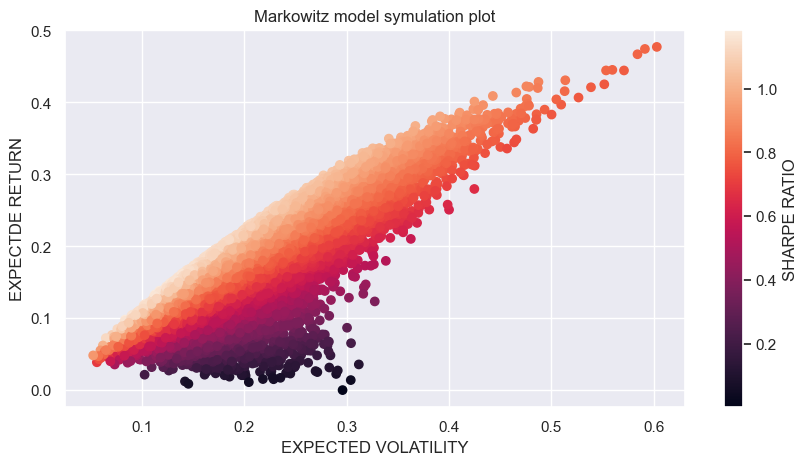

In [9]:
m_model.createResultsPlot(results)

#### 4. Sharp Ratio

In [21]:
new_weights

array([0.08665121, 0.14973164, 0.00057834, 0.19851432, 0.56452448])

In [20]:
maxSR, expected_vol, expected_ret, new_weights = m_model.findHighestSharpRatio(results);

The highest sharp ratio for selected assets is 1.1911
Expected logaritmic annual return: 0.1211
Expected annual volatility: 0.1017
Weights of wallet: [0.08665121 0.14973164 0.00057834 0.19851432 0.56452448]


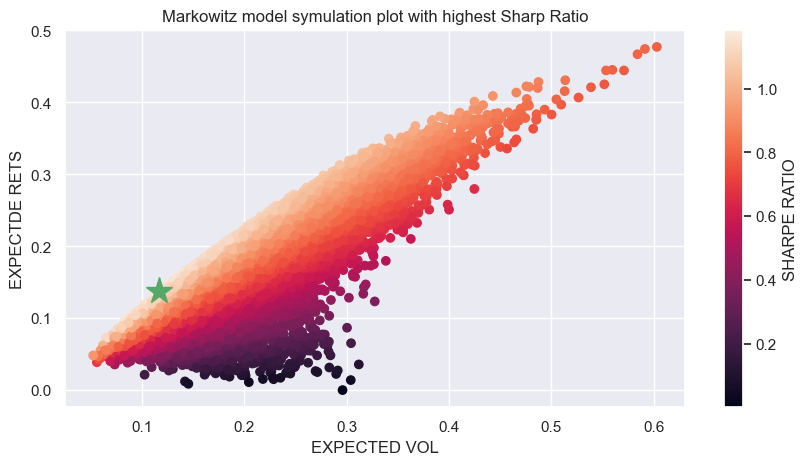

In [11]:
m_model.createResultsPlot2(results, expected_vol, expected_ret)

# NEW: Sortino Ratio

In [22]:
target = 0

In [23]:
def calculate_neg_rets_volatility(weights, log_rets, n, target):

    # We uce covariance instead of log_rets
    neg_log_rets = log_rets[log_rets < target]
    log_rets_cov = neg_log_rets.cov()

    # Calc annual covariance for given weight
    annualized_cov = np.dot(log_rets_cov*n, weights)
    # Use covariance to calculate volotality and std
    vol = np.dot(weights.transpose(),annualized_cov)
    volatility = np.sqrt(vol)

    return volatility

In [24]:
# Chceck how many stock been choesen
N = m_model.calculate_N(df)
# calcl log rets using previos function
log_rets = m_model.calculate_log_rets(df)

# For markowitz portfolio we count this 3 features
portfolio_returns = []
portfolio_vol = []
portfolio_weights = []

# generate portfolios with different weights and calculate volotality and returns
# iteration means how many portfolio we want to generate
for sim in range(iterations):

    weights = m_model.gen_weights(df)
    portfolio_weights.append(weights)

    sim_returns = m_model.calculate_returns(weights, log_rets, n)
    portfolio_returns.append(sim_returns)

    sim_vol = calculate_neg_rets_volatility(weights, log_rets, n, target)
    portfolio_vol.append(sim_vol)

# Create DF wieth all calculated features
results = pd.DataFrame({'weights':portfolio_weights, 'volatility':portfolio_vol, 'returns':portfolio_returns})

In [25]:
# Calculate portfolio with highest sharp ratio
portfolio_vol = results['volatility']
portfolio_returns = results['returns']    
sharpe_ratios = portfolio_returns / portfolio_vol

maxSR = sharpe_ratios.max()
maxSRPosition = sharpe_ratios.argmax()
expected_vol = portfolio_vol[maxSRPosition]
expected_ret = portfolio_returns[maxSRPosition]
new_weights = results['weights'].iloc[maxSRPosition]

print(f'The highest Sortino ratio for selected assets is {round(maxSR,4)}')
print(f'Expected logaritmic annual return: {round(expected_ret,4)}')
print(f'Expected annual volatility: {round(expected_vol,4)}')
print(f'Weights of wallet: {new_weights}')

The highest Sortino ratio for selected assets is 1.3092
Expected logaritmic annual return: 0.1757
Expected annual volatility: 0.1342
Weights of wallet: [0.12340367 0.06510463 0.00374596 0.38188302 0.42586272]


I am not sure if this is correct, becouse sortino should take into account mainly negative returns, so it should increase bond :IEF weight, but in my case algo reduce weight of bond....

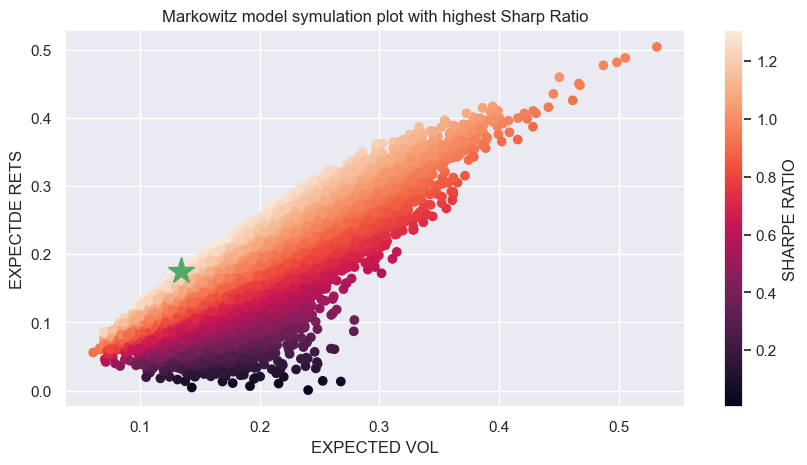

In [26]:
 # Same plot as before but we add star sign where the highest Sharp ratio portfolio is
portfolio_vol = results['volatility']
portfolio_returns = results['returns']
sharpe_ratios = portfolio_returns / portfolio_vol

plt.figure(dpi=100,figsize=(10,5))
plt.scatter(portfolio_vol,portfolio_returns,c=sharpe_ratios)
plt.ylabel('EXPECTDE RETS')
plt.xlabel('EXPECTED VOL')
plt.title('Markowitz model symulation plot with highest Sharp Ratio')

# best sharp ratio by max sharpratio
plt.plot(expected_vol, expected_ret, 'g*', markersize=20.0)


plt.colorbar(label="SHARPE RATIO");
plot = plt.show()

##### Max vol

In [11]:
# Example of how to wtire value
# 10% - 0.1
# 35% - 0.35
max_vol_yearly = 0.25 # 0.00

In [12]:
my_rets, my_vol, sharpRatio, bestWeights = m_model.findBestWeightsByMaxVol(results, max_vol_yearly)

The best portfolio consistent with the assumed annual volatility can achieve an average log return of 27.13%
Proposed portfolio weights: [0.2543861  0.37667867 0.00328864 0.36564659]
Expected sharp ratio: 1.0943562669617068


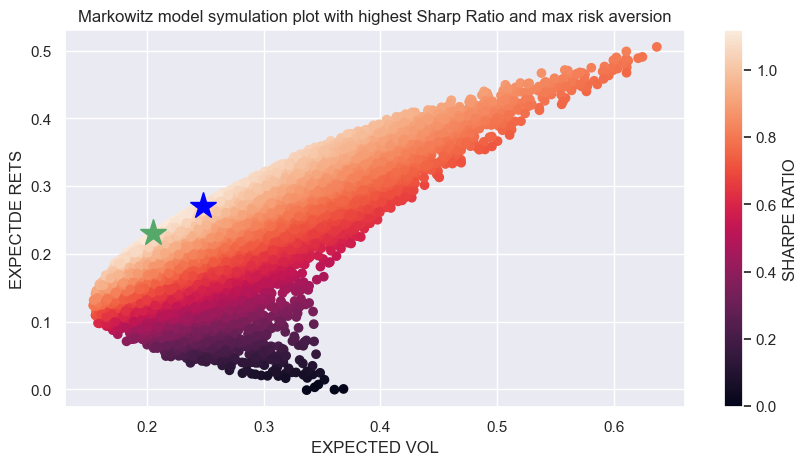

In [13]:
m_model.createResultsPlot3(results, expected_vol, expected_ret, my_vol, my_rets)

In [14]:
summary = m_model.create_summary(maxSR, sharpRatio, expected_vol, my_vol, expected_ret, my_rets, new_weights, bestWeights)
summary

,Sharp Ratio,Expected volatility,Expected log return,Wallet weights
Wallet,,,,
Highest Sharp Ratio,1.119683,0.205815,0.230447,"[0.15868862656319738, 0.46169904154319946, 0.0..."
My Choice,1.094356,0.247876,0.271265,"[0.2543860953780623, 0.3766786678603265, 0.003..."


In [15]:
HighestSR = Checkbox(description = 'Highest Sharp Ratio')
MyWallet = Checkbox(description = 'My Choice')

In [16]:
display(HighestSR, MyWallet)

Checkbox(value=False, description='Highest Sharp Ratio')

Checkbox(value=False, description='My Choice')

In [17]:
wallet = m_model.choese_wallet(HighestSR, MyWallet)

Your choice: ['My Choice']


In [23]:
weights = m_model.create_weightsDataFrame(summary, wallet, df)
weights

,BTC-USD,CSPX.L,BNO,AMZN
0,0.2543860953780623,0.3766786678603265,0.0032886427457575963,0.3656465940158537


In [24]:
weights.to_csv('portfolioWeights.csv', header=True)